In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset, load_metric, ClassLabel, Sequence
import transformers
import pandas as pd
from IPython.display import display, HTML
import random
import numpy as np
import collections
from tqdm.auto import tqdm

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

transformers.__version__

Using cuda:0 device


'4.35.0'

In [3]:
squad_v2 = True
model_checkpoint = "distilbert-base-uncased"
batch_size = 32
max_length = 384
doc_stride = 128
n_best_size = 20
max_answer_length = 30

## Loading the dataset

In [4]:
datasets1={}

In [5]:
datasets1['train'] = load_dataset("squad", split='train[:90%]' if squad_v2 else "squad_v2")
datasets1['validation'] = load_dataset("squad", split='train[90%:100%]' if squad_v2 else "squad_v2")
datasets1['test'] = load_dataset("squad", split='validation' if squad_v2 else "squad_v2")

In [6]:
datasets1

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 78839
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 8760
 }),
 'test': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 10570
 })}

In [7]:
from datasets import Dataset, DatasetDict
datasets= DatasetDict(datasets1)

In [8]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [9]:
datasets["validation"][0]

{'id': '57344767acc1501500babd8b',
 'title': 'Richmond,_Virginia',
 'context': 'The city is home to many monuments and memorials, most notably those along Monument Avenue. Other monuments include the A.P. Hill monument, the Bill "Bojangles" Robinson monument in Jackson Ward, the Christopher Columbus monument near Byrd Park, and the Confederate Soldiers and Sailors Monument on Libby Hill. Located near Byrd Park is the famous World War I Memorial Carillon, a 56-bell carillon tower. Dedicated in 1956, the Virginia War Memorial is located on Belvedere overlooking the river, and is a monument to Virginians who died in battle in World War II, the Korean War, the Vietnam War, the Gulf War, the War in Afghanistan, and the Iraq War.',
 'question': 'How many bells are contained in the World War I Memorial Carillon?',
 'answers': {'text': ['56'], 'answer_start': [381]}}

In [10]:
# Show random elements in the dataset
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [11]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,572763d9dd62a815002e9c01,Late_Middle_Ages,"The ideas of the Italian Renaissance were slow to cross the Alps into northern Europe, but important artistic innovations were made also in the Low Countries. Though not – as previously believed – the inventor of oil painting, Jan van Eyck was a champion of the new medium, and used it to create works of great realism and minute detail. The two cultures influenced each other and learned from each other, but painting in the Netherlands remained more focused on textures and surfaces than the idealized compositions of Italy.",Jan van Eyck's paintings are known for what characteristics?,"{'text': ['great realism and minute detail'], 'answer_start': [305]}"
1,572e9358cb0c0d14000f12ee,Richard_Feynman,"In a 1992 New York Times article on Feynman and his legacy, James Gleick recounts the story of how Murray Gell-Mann described what has become known as ""The Feynman Algorithm"" or ""The Feynman Problem-Solving Algorithm"" to a student: ""The student asks Gell-Mann about Feynman's notes. Gell-Mann says no, Dick's methods are not the same as the methods used here. The student asks, well, what are Feynman's methods? Gell-Mann leans coyly against the blackboard and says: Dick's method is this. You write down the problem. You think very hard. (He shuts his eyes and presses his knuckles parodically to his forehead.) Then you write down the answer.""","Gleick told a story about a specific algorithim that Gell-Mann described to a student, what was this algorithim called?","{'text': ['The Feynman Problem-Solving Algorithm'], 'answer_start': [179]}"
2,571023c2a58dae1900cd6903,Capital_punishment_in_the_United_States,"Sixteen was held to be the minimum permissible age in the 1988 Supreme Court decision of Thompson v. Oklahoma. The Court, considering the case Roper v. Simmons in March 2005, found the execution of juvenile offenders unconstitutional by a 5–4 margin, effectively raising the minimum permissible age to 18. State laws have not been updated to conform with this decision. In the American legal system, unconstitutional laws do not need to be repealed; instead, they are held to be unenforceable. (See also List of juvenile offenders executed in the United States)","In Roper v. Simmons, how many Supreme Court justices believed juvenile execution to be unconstitutional?","{'text': ['5'], 'answer_start': [239]}"
3,57339840d058e614000b5e4e,Alfred_North_Whitehead,"Margaret Stout and Carrie M. Staton have also written recently on the mutual influence of Whitehead and Mary Parker Follett, a pioneer in the fields of organizational theory and organizational behavior. Stout and Staton see both Whitehead and Follett as sharing an ontology that ""understands becoming as a relational process; difference as being related, yet unique; and the purpose of becoming as harmonizing difference."" This connection is further analyzed by Stout and Jeannine M. Love in Integrative Process: Follettian Thinking from Ontology to Administration",What book did Stout and Jeanine M. Love author that further examines the on between Whitehead and Follett?,"{'text': ['Integrative Process: Follettian Thinking from Ontology to Administration'], 'answer_start': [492]}"
4,5727f4402ca10214002d9a2e,Time,"Two contrasting viewpoints on time divide many prominent philosophers. One view is that time is part of the fundamental structure of the universe—a dimension independent of events, in which events occur in sequence. Sir Isaac Newton subscribed to this realist view, and hence it is sometimes referred to as Newtonian time. The opposing view is that time does not refer to any kind of ""container"" that events and objects ""move through"", nor to any entity that ""flows"", but that it is instead part of a fundamental intellectual structure (together with space and number) within which humans sequence and compare events. This second view, in the tradition of Gottfried Leibniz and Immanuel Kant, holds that time

## Preprocessing the training data

In [12]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [13]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [14]:
tokenizer("What is your name?", "My name is Minhah.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 19538, 4430, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

In [16]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

In [17]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [18]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [19]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

In [20]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

In [21]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

In [22]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


In [23]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [24]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 26


In [25]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


In [26]:
pad_on_right = tokenizer.padding_side == "right"

In [27]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# Move model to GPU
model.to(device)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [28]:
# Preprocessing the training data
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    tokenized_examples = tokenizer(
        examples["question" if tokenizer.padding_side == "right" else "context"],
        examples["context" if tokenizer.padding_side == "right" else "question"],
        truncation="only_second" if tokenizer.padding_side == "right" else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(tokenized_examples["offset_mapping"]):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if tokenizer.padding_side == "right" else 0):
                token_start_index += 1
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if tokenizer.padding_side == "right" else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [29]:
features = prepare_train_features(datasets['train'][:5])

In [30]:
# Map training features to GPU
tokenized_datasets = datasets.map(
    prepare_train_features,
    batched=True,
    remove_columns=datasets["train"].column_names
)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

Map:   0%|          | 0/78839 [00:00<?, ? examples/s]

Map:   0%|          | 0/8760 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

## Fine-tuning the model

In [31]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=True,
)

In [32]:
data_collator = default_data_collator

In [33]:
# Define trainer
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


In [34]:
trainer.train()

/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.349100,1.133381
2,0.940700,1.065191
3,0.674200,1.118573
4,0.499200,1.233579
5,0.393400,1.350209


/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance

TrainOutput(global_step=6230, training_loss=0.8181369187552512, metrics={'train_runtime': 5202.4549, 'train_samples_per_second': 76.583, 'train_steps_per_second': 1.198, 'total_flos': 3.904110608606208e+16, 'train_loss': 0.8181369187552512, 'epoch': 5.0})

In [35]:
trainer.save_model("test-squadv1-trained")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

events.out.tfevents.1702353578.a100.2414618.0:   0%|          | 0.00/7.75k [00:00<?, ?B/s]

## Evaluation

In [36]:
# Evaluation
for batch in trainer.get_eval_dataloader():
    break

batch = {k: v.to(device) for k, v in batch.items()}
with torch.no_grad():
    output = model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [37]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

In [38]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 91, 131,  51, 110, 143,  79, 136,  39,  54,  43,  82, 155, 146,  24,
          38, 118, 114,  85,  97, 119, 152,  54,  38,  10,  56,  67, 124,  31,
          90, 116, 152,  25,  77, 109, 133, 134,  42,  55,  35, 130, 160,  32,
          44,  73, 105, 182,  32,  50,  97, 114, 160,  49,  67,  85,  99, 117,
          39,  31,  10, 105, 107,  61,  51, 116], device='cuda:0'),
 tensor([ 91, 133,  52, 111, 143,  80, 139,  42,  58,  43,  84, 157, 146,  25,
          39, 119, 114,  85,  99, 123, 153,  63,  39,  12,  57,  69, 127,  32,
          90, 117, 153,  29,  78, 110, 133, 135,  44,  56,  36, 133, 160,  33,
          46,  73, 105, 185,  32,  73,  99, 115, 160,  51,  69,  85,  99, 119,
          41,  33,  14, 105, 110,  64,  53, 116], device='cuda:0'))

In [39]:
n_best_size = 20

In [40]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [41]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [42]:
# Map validation features to GPU
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [43]:
# Predictions on GPU
raw_predictions = trainer.predict(validation_features)

In [44]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [45]:
max_answer_length = 30

In [46]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 14.741957, 'text': 'at'},
 {'score': 9.642338, 'text': 'at Santa Clara'},
 {'score': 6.294062, 'text': 'at Santa Clara, California.'},
 {'score': 5.0391455, 'text': 'at Santa'},
 {'score': 2.6526132, 'text': 'at Santa Clara, California'},
 {'score': 1.7820973, 'text': 'at Santa Clara,'},
 {'score': 1.7423787, 'text': 'Area at'},
 {'score': 1.5496984, 'text': 's Stadium in the San Francisco Bay Area at'},
 {'score': 1.2149415, 'text': 'at Santa Clara, California. As'},
 {'score': 1.0691648, 'text': 'the San Francisco Bay Area at'},
 {'score': 0.33892345, 'text': 'at Santa Clara, California. As this was the'},
 {'score': -0.6014228, 'text': 'San Francisco Bay Area at'},
 {'score': -0.7314887,
  'text': "played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at"},
 {'score': -0.7764697, 'text': 'in the San Francisco Bay Area at'},
 {'score': -0.8463416, 'text': 'Francisco Bay Area at'},
 {'score': -1.1083369,
  'text': "Bowl title. The game was played on Fe

In [47]:
datasets["test"][0]["answers"]

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

In [48]:
import collections

examples = datasets["test"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [49]:
# Postprocess QA predictions
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)

    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        min_null_score = None
        valid_answers = []
        context = example["context"]

        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1: -n_best_size - 1: -1].tolist()
            end_indexes = np.argsort(end_logits)[-1: -n_best_size - 1: -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue

                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

# Map validation features to GPU
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

# Predictions on GPU
raw_predictions = trainer.predict(validation_features)

In [50]:
# Postprocess predictions
final_predictions = postprocess_qa_predictions(datasets["test"], validation_features, raw_predictions.predictions)

Post-processing 10570 example predictions split into 10784 features.


  0%|          | 0/10570 [00:00<?, ?it/s]

In [51]:
metric = load_metric("squad" if squad_v2 else "squad_v2")

/tmp/ipykernel_2414618/1165241577.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad" if squad_v2 else "squad_v2")


In [53]:
metric = load_metric("squad" if squad_v2 else "squad_v2")

if not squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["test"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 75.89403973509934, 'f1': 84.62013581517354}

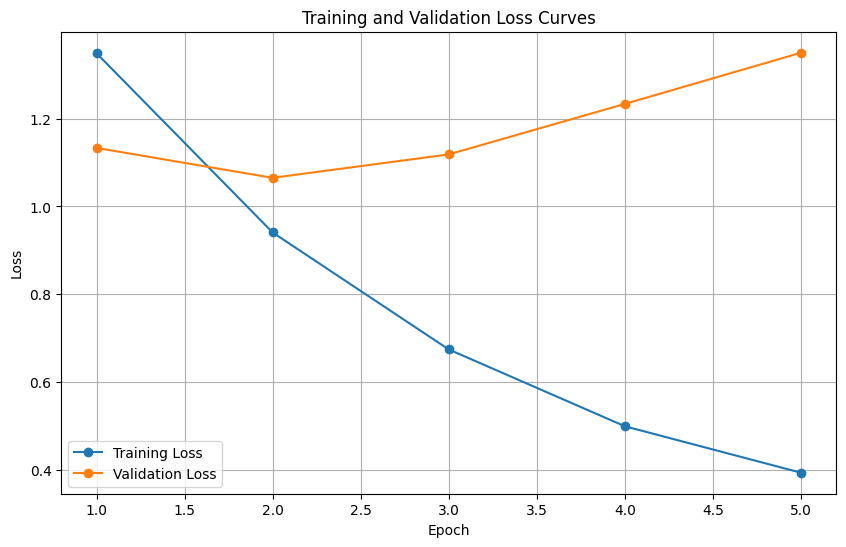

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with your data
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.349100,0.940700,0.674200,0.499200,0.393400],
    'Validation Loss': [1.133381,1.065191,1.118573,1.233579,1.350209]
}

df = pd.DataFrame(data)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()
